# PyKOALA Data Reduction Sequence (Science data)

In [17]:
from matplotlib import pyplot as plt
import numpy as np
import os
from koala import __version__
import warnings

# You may want to comment the following line
warnings.filterwarnings("ignore")
print("pyKOALA version: ", __version__)

pyKOALA version:  0.2.1+1.g1dcd178.dirty


In [18]:
from koala.corrections.atmospheric_corrections import AtmosphericExtinction, get_adr
from koala.corrections.throughput import Throughput

from koala.register.registration import register_stars
from koala.cubing import build_cube

from koala.plotting.qc_plot import qc_cube

atm_ext_corr = AtmosphericExtinction()

flat_rss = [koala_rss(f"data/07sep{aaomega_arms[arm]}00{flat}red.fits") for flat in [11, 12, 13, 14]]
throughput, throughput_std = Throughput.create_throughput_from_flat(flat_rss, clear_nan=True)
throughput_corr = Throughput()

[Correction: AtmosphericExtinction] Initialising Atm ext. correction model.
[Correction: AtmosphericExtinction] No extinction provided
[Correction: AtmosphericExtinction] Computing extinction at airmass 1.0 based on model:
    /home/pablo/Develop/koala/src/koala/corrections/../input_data/observatory_extinction/ssoextinct.dat


In [19]:
from koala.koala_ifu import koala_rss

sci_rss = []
aaomega_arms = {'blue': 1, 'red': 2}
# Choose which arm of the spectrograph is going to be used
arm = 'blue'
path_to_data = 'data'

adr_x_set = []
adr_y_set = []
    
for i in [61, 62]:
    filename = f"{path_to_data}/07sep{aaomega_arms[arm]}00{i}red.fits"
    rss = koala_rss(filename)
    
    rss = throughput_corr.apply(throughput, rss)
    rss = atm_ext_corr.apply(rss)
    # Telluric
    # Sky
    
    adr_x, adr_y, fig = get_adr(rss, plot=True)
    adr_x_set.append(adr_x)
    adr_y_set.append(adr_y)
    print(f"File {filename} corresponds to object {rss.header['OBJECT']}")
    sci_rss.append(rss)

[Correction: AtmosphericExtinction] Applying model-based extinction correction to RSS file
File data/07sep10061red.fits corresponds to object NGC1311 a
[Correction: AtmosphericExtinction] Applying model-based extinction correction to RSS file
File data/07sep10062red.fits corresponds to object NGC1311 b


In [ ]:
dummy_wave, dummy_response = np.loadtxt('data/instrument_response.dat', unpack=True)

register_stars(sci_rss, moffat=False, plot=False, com_power=4)
cube = build_cube(rss_set=sci_rss,
                  reference_coords=(0., 0.),
                  reference_pa=0.,
                  cube_size_arcsec=(30, 50),  # (dec, ra)
                  pixel_size_arcsec=.5,
                  adr_x_set=adr_x_set, adr_y_set=adr_y_set)
cube.info['name'] = rss.info['name'].split(' ')[0]

instrument_response = np.interp(cube.wavelength, dummy_wave, dummy_response)

[Flux Calib.] Applying response function to NGC1311


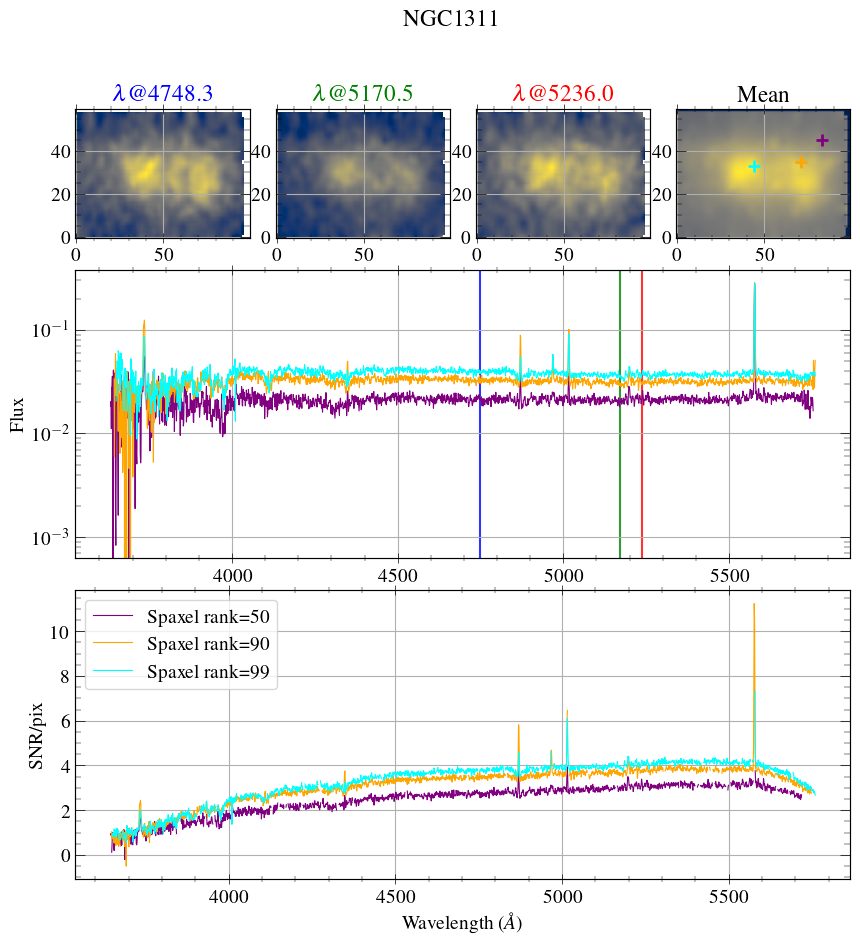

In [21]:
from koala.corrections.flux_calibration import FluxCalibration

FluxCalibration.apply(instrument_response, cube)
# you can save the cube using the following function
#cube.to_fits(fname=os.path.join(output, 'ngc1311.fits.gz'))

fig = qc_cube(cube)